# Friendnet Dataset Preprocessing

Here we'd try to prepare the raw data to it's usable format.

# Import All Libraries

In [155]:
import os
import pyheif
import imageio
import random
import shutil
import types
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import open_clip
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
from captum.attr import IntegratedGradients
# !pip install pyheif
# !pip install grad-cam
# pip install open-clip-torch
# !pip install captum

# Dataset Preprocessing

## Preprocess Setup

In [ ]:
# List friends and Tensor transformation
friends = ["tatyana", "uzair", "jacob", "luke", "osama"]
base_dir = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/dataset/"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Process Tatyana (HEIC images + one video)

In [ ]:
friend = "tatyana"
friend_dir = os.path.join(base_dir, friend)
video_path = os.path.join(friend_dir, "video.MOV")
video_out = os.path.join(friend_dir, "video_frames")
heic_out = os.path.join(friend_dir, "converted_images")
final_out = os.path.join(base_dir, "final_dataset", friend)

os.makedirs(video_out, exist_ok=True)
os.makedirs(heic_out, exist_ok=True)
os.makedirs(final_out, exist_ok=True)

# Extract frames from video
reader = imageio.get_reader(video_path)
for idx, frame in tqdm(enumerate(reader), desc="Extracting frames from Tatyana video"):
    if idx % 10 == 0:
        img = Image.fromarray(frame)
        img.save(os.path.join(video_out, f"frame_{idx:04d}.jpg"))

# Convert HEIC to JPG
heic_files = [f for f in os.listdir(friend_dir) if f.lower().endswith(".heic")]
for file in tqdm(heic_files, desc="Converting HEICs for Tatyana"):
    heif_file = pyheif.read(os.path.join(friend_dir, file))
    img = Image.frombytes(
        heif_file.mode, heif_file.size, heif_file.data,
        "raw", heif_file.mode, heif_file.stride
    )
    img.save(os.path.join(heic_out, file.replace(".heic", ".jpg")))

# Preprocess
i = 0
for src in [video_out, heic_out]:
    for file in tqdm(os.listdir(src), desc=f"Preprocessing {os.path.basename(src)}"):
        if file.endswith(".jpg"):
            img = Image.open(os.path.join(src, file)).convert("RGB")
            tensor = transform(img)
            out_img = transforms.ToPILImage()(tensor)
            out_img.save(os.path.join(final_out, f"{i:04d}.jpg"))
            i += 1

Extracting frames from Tatyana video: 3067it [02:56, 17.35it/s]
Preprocessing converted_images: 100%|██████████| 140/140 [00:26<00:00,  5.38it/s]


## Extract Frames from Videos (Other Friends)

In [ ]:
for friend in ["uzair", "jacob", "luke", "osama"]:
    print(f"\n Extracting for {friend}")
    friend_dir = os.path.join(base_dir, friend)
    video_out = os.path.join(friend_dir, "video_frames")
    os.makedirs(video_out, exist_ok=True)

    videos = ["video.MOV"]
    if friend == "osama":
        videos.append("video2.MOV")

    for vid in videos:
        video_path = os.path.join(friend_dir, vid)
        try:
            reader = imageio.get_reader(video_path)
            for idx, frame in tqdm(enumerate(reader), desc=f"{friend} - {vid}"):
                if idx % 10 == 0:
                    img = Image.fromarray(frame)
                    out_name = f"{vid.replace('.MOV','')}_{idx:04d}.jpg"
                    img.save(os.path.join(video_out, out_name))
        except Exception as e:
            print(f"Error with {friend} - {vid}: {e}")


 Extracting for uzair


uzair - video.MOV: 7618it [06:29, 19.55it/s]



 Extracting for jacob


jacob - video.MOV: 7612it [06:23, 19.87it/s]



 Extracting for luke


luke - video.MOV: 8597it [07:12, 19.88it/s]



 Extracting for osama


osama - video.MOV: 7053it [05:47, 20.28it/s]
osama - video2.MOV: 1172it [01:00, 19.26it/s]


### Preprocess Extracted Frames

In [ ]:
for friend in ["uzair", "jacob", "luke", "osama"]:
    input_dir = os.path.join(base_dir, friend, "video_frames")
    output_dir = os.path.join(base_dir, "final_dataset", friend)
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n Preprocessing frames for {friend}")
    files = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
    for i, file in enumerate(tqdm(files, desc=f"{friend} - transform & save")):
        img = Image.open(os.path.join(input_dir, file)).convert("RGB")
        tensor = transform(img)
        out_img = transforms.ToPILImage()(tensor)
        out_img.save(os.path.join(output_dir, f"{i:04d}.jpg"))


 Preprocessing frames for uzair


uzair - transform & save: 100%|██████████| 762/762 [00:41<00:00, 18.29it/s]



 Preprocessing frames for jacob


jacob - transform & save: 100%|██████████| 762/762 [00:39<00:00, 19.32it/s]



 Preprocessing frames for luke


luke - transform & save: 100%|██████████| 860/860 [00:44<00:00, 19.37it/s]



 Preprocessing frames for osama


osama - transform & save: 100%|██████████| 824/824 [00:40<00:00, 20.35it/s]


## Split dataset 70% Training, 15% Test and 15% Validation

In [ ]:
# Define source and output paths
source_dir = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/dataset/FRIENDNETSET_FULL"
split_dir = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/dataset/FRIENDNETSET"

friends = ["tatyana", "uzair", "jacob", "luke", "osama"]
target_counts = {"train": 700, "val": 150, "test": 150}

# Create output folders
for split in target_counts:
    for friend in friends:
        os.makedirs(os.path.join(split_dir, split, friend), exist_ok=True)

# Split and copy images
for friend in tqdm(friends, desc="Splitting friends"):
    src = os.path.join(source_dir, friend)
    images = [f for f in os.listdir(src) if f.endswith(".jpg")]
    random.shuffle(images)

    # Determine base sizes first
    train_cut = min(target_counts["train"], int(0.7 * len(images)))
    val_cut = min(target_counts["val"], int(0.15 * len(images)))
    test_cut = min(target_counts["test"], len(images) - train_cut - val_cut)

    train_imgs = images[:train_cut]
    val_imgs = images[train_cut:train_cut + val_cut]
    test_imgs = images[train_cut + val_cut:train_cut + val_cut + test_cut]

    for split_name, split_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        for img in split_imgs:
            src_path = os.path.join(src, img)
            dst_path = os.path.join(split_dir, split_name, friend, img)
            shutil.copy(src_path, dst_path)

Splitting friends: 100%|██████████| 5/5 [01:07<00:00, 13.57s/it]


## Augment Missing Images

In [ ]:
# Define transformations and augmentation
augment_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    T.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.9, 1.1))
])

def augment_images(split, friend, target_count):
    input_dir = os.path.join(split_dir, split, friend)
    images = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
    current_count = len(images)

    if current_count >= target_count:
        print(f"{friend} - {split}: already has {current_count}")
        return

    needed = target_count - current_count
    print(f"Augmenting {friend} - {split}: {current_count} → {target_count} (+{needed})")

    for i in tqdm(range(needed), desc=f"{friend}-{split}", leave=False):
        original = random.choice(images)
        img_path = os.path.join(input_dir, original)

        try:
            img = Image.open(img_path).convert("RGB")
            aug_img = augment_transform(img)
            aug_name = f"aug_{i:04d}.jpg"
            aug_img.save(os.path.join(input_dir, aug_name))
        except Exception as e:
            print(f"Error on {img_path}: {e}")

### Augment Across Splits

In [ ]:
for split, count in target_counts.items():
    print(f"\n Split: {split.upper()}")
    for friend in tqdm(friends, desc=f"Augmenting {split}", leave=True):
        augment_images(split, friend, count)

print("\n All splits and classes now balanced: 700 train / 150 val / 150 test each.")


 Split: TRAIN


Augmenting train:   0%|          | 0/5 [00:00<?, ?it/s]

Augmenting tatyana - train: 312 → 700 (+388)



Augmenting train:  20%|██        | 1/5 [00:10<00:42, 10.51s/it]

Augmenting uzair - train: 518 → 700 (+182)



Augmenting train:  40%|████      | 2/5 [00:15<00:22,  7.54s/it]

Augmenting jacob - train: 524 → 700 (+176)



Augmenting train:  60%|██████    | 3/5 [00:22<00:14,  7.00s/it]

Augmenting luke - train: 536 → 700 (+164)



Augmenting train:  80%|████████  | 4/5 [00:27<00:06,  6.41s/it]

Augmenting osama - train: 576 → 700 (+124)



Augmenting train: 100%|██████████| 5/5 [00:32<00:00,  6.50s/it]



 Split: VAL


Augmenting val:   0%|          | 0/5 [00:00<?, ?it/s]

Augmenting tatyana - val: 67 → 150 (+83)



Augmenting val:  20%|██        | 1/5 [00:01<00:07,  1.86s/it]

Augmenting uzair - val: 111 → 150 (+39)



Augmenting val:  40%|████      | 2/5 [00:03<00:04,  1.44s/it]

Augmenting jacob - val: 112 → 150 (+38)



Augmenting val:  60%|██████    | 3/5 [00:04<00:02,  1.40s/it]

Augmenting luke - val: 114 → 150 (+36)



Augmenting val:  80%|████████  | 4/5 [00:05<00:01,  1.26s/it]

Augmenting osama - val: 123 → 150 (+27)



Augmenting val: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]



 Split: TEST


Augmenting test:   0%|          | 0/5 [00:00<?, ?it/s]

Augmenting tatyana - test: 68 → 150 (+82)



Augmenting test:  20%|██        | 1/5 [00:01<00:06,  1.75s/it]

Augmenting uzair - test: 111 → 150 (+39)



Augmenting test:  40%|████      | 2/5 [00:02<00:03,  1.33s/it]

Augmenting jacob - test: 113 → 150 (+37)



Augmenting test:  60%|██████    | 3/5 [00:03<00:02,  1.17s/it]

Augmenting luke - test: 116 → 150 (+34)



Augmenting test:  80%|████████  | 4/5 [00:04<00:01,  1.07s/it]

Augmenting osama - test: 125 → 150 (+25)



Augmenting test: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


 All splits and classes now balanced: 700 train / 150 val / 150 test each.


## Preview Before/After (One per Friend)


 Previewing tatyana


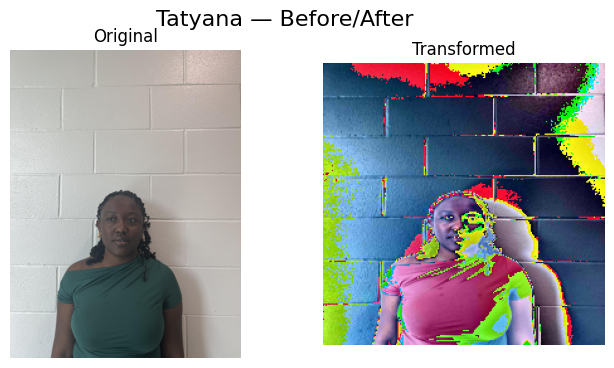


 Previewing uzair


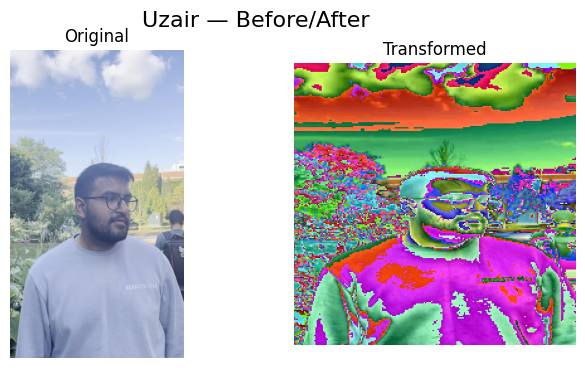


 Previewing jacob


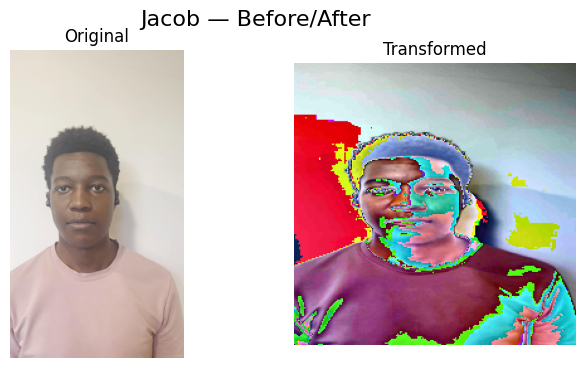


 Previewing luke


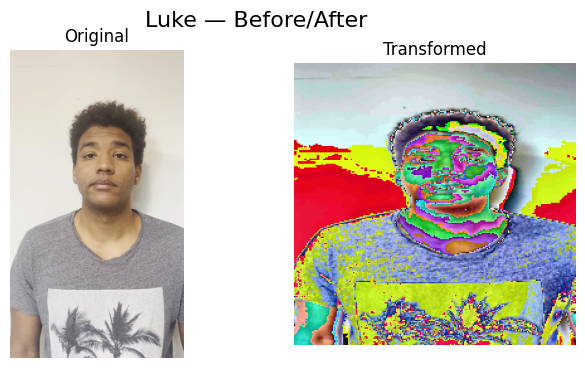


 Previewing osama


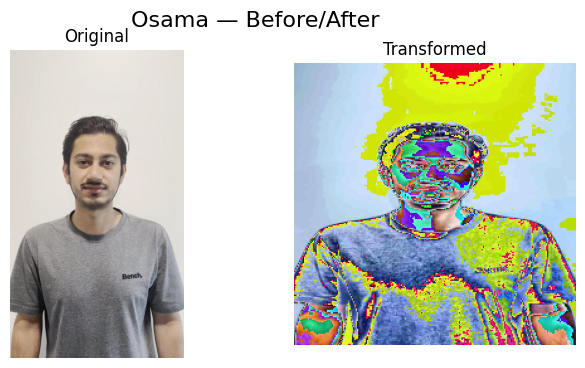

In [ ]:
for friend in friends:
    print(f"\n Previewing {friend}")
    raw_dir = os.path.join(base_dir, friend, "video_frames" if friend != "tatyana" else "converted_images")
    sample_dir = os.path.join(base_dir, "final_dataset", friend)

    raw_images = [f for f in os.listdir(raw_dir) if f.endswith(".jpg")]
    if not raw_images:
        print(f"No image found for {friend}")
        continue

    raw_path = os.path.join(raw_dir, raw_images[0])
    img = Image.open(raw_path).convert("RGB")
    img_trans = transform(img)
    img_post = transforms.ToPILImage()(img_trans)

    plt.figure(figsize=(8, 4))
    plt.suptitle(f"{friend.capitalize()} — Before/After", fontsize=16)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img_post)
    plt.title("Transformed")
    plt.axis("off")
    plt.show()

# Configurations

In [17]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set Seeders for Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset Loaders
base_path = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/dataset/FRIENDNETSET"

train_dataset = datasets.ImageFolder(root=os.path.join(base_path, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(base_path, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(base_path, "test"), transform=transform)

batch_size = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

Using device: cuda:0


## Check Visuals for a Batch

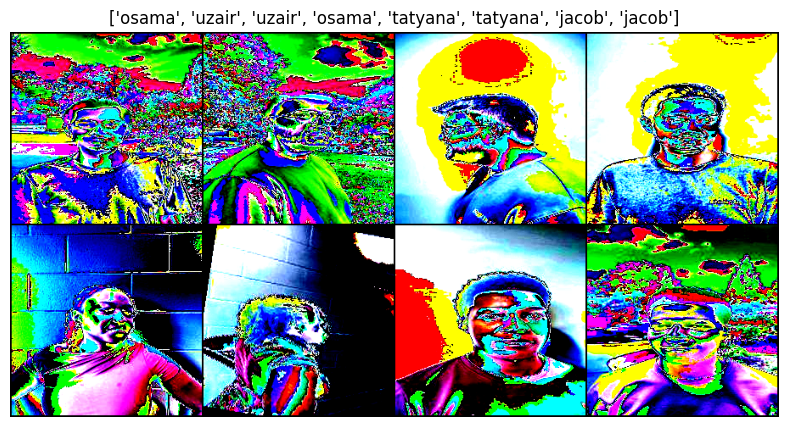

In [6]:
images, labels = next(iter(train_loader))
grid_img = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(10,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title([train_dataset.classes[label] for label in labels[:8]])
plt.axis('off')
plt.show()

# Build Custom CNN (FriendNet)

In [18]:
class FriendNet(nn.Module):
  def __init__(self, num_classes=5):
    super(FriendNet, self).__init__()

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2)

    # Batch Norms & Dropouts
    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)

    self.dropout = nn.Dropout(0.5)

    # Dense Layer
    self.fc = nn.Linear(256 * 28 * 28, 512)
    self.out = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))

    x = x.view(x.size(0), -1)
    x = self.dropout(F.relu(self.fc(x)))
    x = self.out(x)
    return x

print(FriendNet())

FriendNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200704, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=5, bias=True)
)


## Define Hyperparameters

In [82]:
criterion = nn.CrossEntropyLoss()
model = FriendNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
epochs = 30

print("Loss Fn", criterion)
print("Batch Size", batch_size)
print("Epochs", epochs)
print("Optimizer", optimizer)

Loss Fn CrossEntropyLoss()
Batch Size 30
Epochs 30
Optimizer SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## Training & Validation

In [83]:
print("Training...")

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# EARLY STOPPING CONFIG
patience = 10  # Number of epochs to wait before stopping
best_val_loss = float('inf')
early_stop_counter = 0

# path to save the best model
best_model_path = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/model/best_friendnet_model.pth"

for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Train Loader"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * images.size(0)

    train_losses.append(train_loss / total)
    train_accuracy.append(100 * train_correct / total)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation Loader"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_total += labels.size(0)
            val_running_loss += loss.item() * images.size(0)
            val_correct += (pred == labels).sum().item()

    current_val_loss = val_running_loss / val_total
    current_val_accuracy = 100 * val_correct / val_total
    val_losses.append(current_val_loss)
    val_accuracy.append(current_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_accuracy:.2f}%")

    # EARLY STOPPING CHECK
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Finished Training.")

Training...


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 0.6710, Val Loss: 0.2495, Val Acc: 92.53%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 0.1895, Val Loss: 0.1576, Val Acc: 96.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 0.1133, Val Loss: 0.1203, Val Acc: 96.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 0.0747, Val Loss: 0.0972, Val Acc: 98.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 0.0546, Val Loss: 0.0928, Val Acc: 98.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 0.0407, Val Loss: 0.0782, Val Acc: 98.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 0.0331, Val Loss: 0.0725, Val Acc: 98.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 0.0277, Val Loss: 0.0657, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 0.0235, Val Loss: 0.0629, Val Acc: 98.40%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.0196, Val Loss: 0.0596, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 0.0182, Val Loss: 0.0581, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 0.0161, Val Loss: 0.0574, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 0.0138, Val Loss: 0.0516, Val Acc: 98.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 0.0126, Val Loss: 0.0529, Val Acc: 98.53%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.0119, Val Loss: 0.0518, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 0.0103, Val Loss: 0.0510, Val Acc: 98.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 0.0093, Val Loss: 0.0500, Val Acc: 98.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 0.0090, Val Loss: 0.0476, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 0.0083, Val Loss: 0.0474, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.0082, Val Loss: 0.0441, Val Acc: 98.93%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 0.0072, Val Loss: 0.0444, Val Acc: 98.93%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 0.0068, Val Loss: 0.0459, Val Acc: 98.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 0.0065, Val Loss: 0.0483, Val Acc: 98.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 0.0056, Val Loss: 0.0462, Val Acc: 98.93%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.0058, Val Loss: 0.0448, Val Acc: 98.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 0.0058, Val Loss: 0.0439, Val Acc: 98.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss: 0.0050, Val Loss: 0.0432, Val Acc: 98.93%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss: 0.0052, Val Loss: 0.0430, Val Acc: 98.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss: 0.0048, Val Loss: 0.0413, Val Acc: 98.93%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 0.0044, Val Loss: 0.0429, Val Acc: 98.80%
Finished Training.


### Train & Validation Visuals

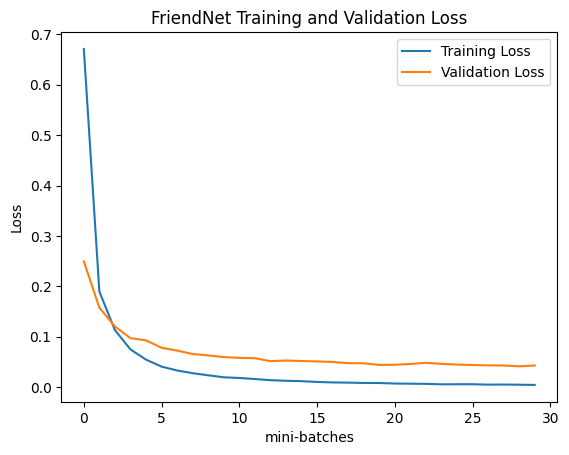

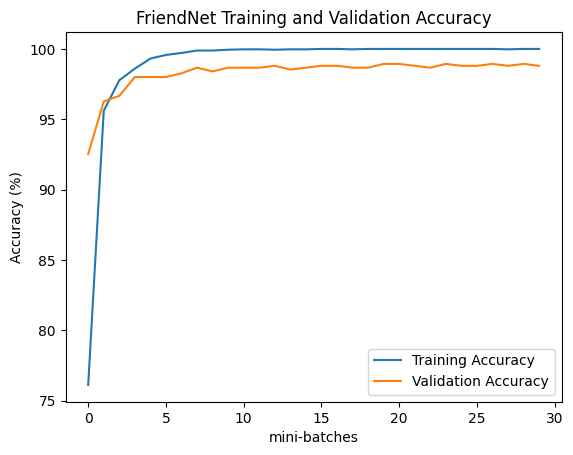

In [84]:
# Plot training loss over time
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('FriendNet Training and Validation Loss')
plt.xlabel('mini-batches')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy over time
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('FriendNet Training and Validation Accuracy')
plt.xlabel('mini-batches')
plt.ylabel('Accuracy (%)')
plt.legend()

### Feature Importance

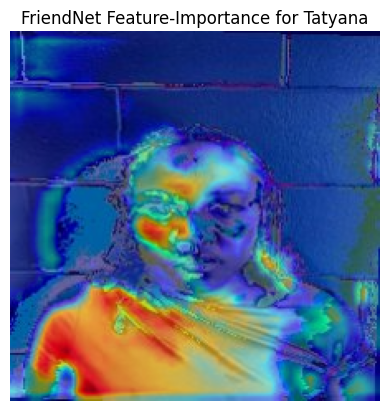

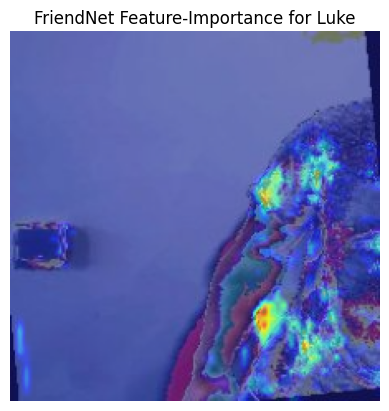

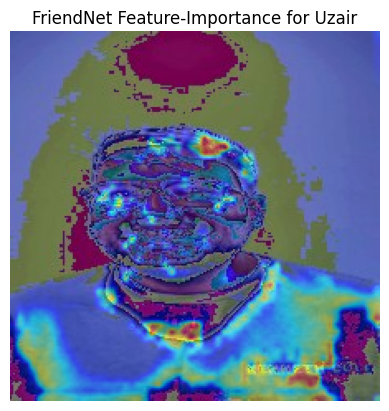

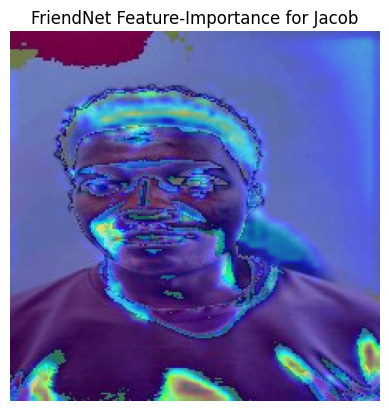

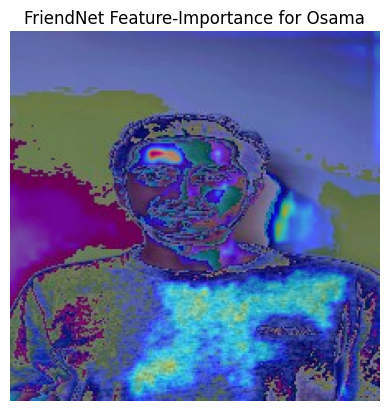

In [85]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/model/best_friendnet_model.pth"))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def preprocess(img_path):
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0
    tensor = normalize(transform(img)).unsqueeze(0).to(device)
    return img_np, tensor

target_layer = model.conv3

class_names = ["tatyana", "luke", "uzair", "jacob", "osama"]

cam = GradCAM(model=model, target_layers=[target_layer])

for class_idx, class_name in enumerate(class_names):
    folder = f"/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/dataset/FRIENDNETSET/test/{class_name}"
    sample_image = random.choice(os.listdir(folder))

    img_path = os.path.join(folder, sample_image)
    original_img, input_tensor = preprocess(img_path)

    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    visualization = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(f"FriendNet Feature-Importance for {class_name.capitalize()}")
    plt.axis("off")
    plt.show()

## Model Evaluation

In [86]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"FriendNet Accuracy : {accuracy:.4f}")
print(f"FriendNet Precision: {precision:.4f}")
print(f"FriendNet Recall   : {recall:.4f}")
print(f"FriendNet F1 Score : {f1:.4f}")

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

FriendNet Accuracy : 0.9880
FriendNet Precision: 0.9881
FriendNet Recall   : 0.9880
FriendNet F1 Score : 0.9880


### Evaluation Visuals

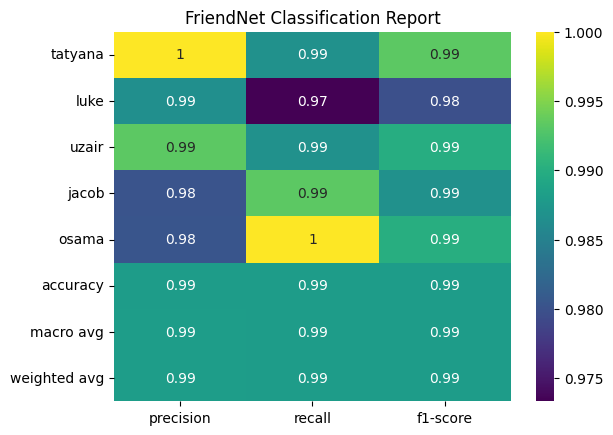

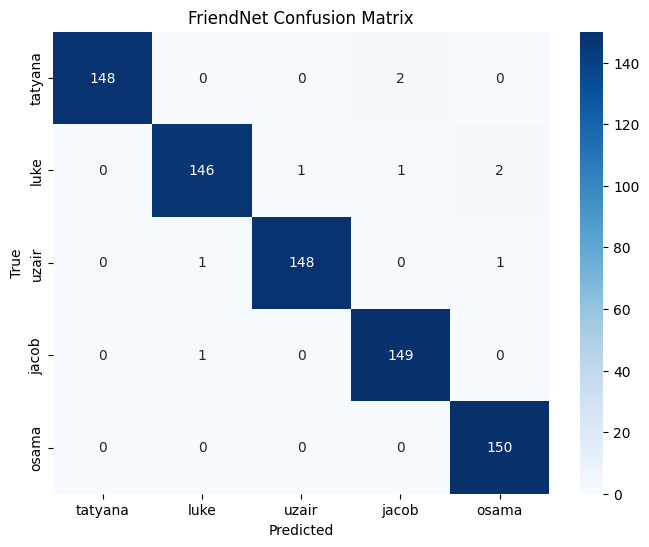

In [87]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='viridis')
plt.title('FriendNet Classification Report')
plt.show()

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('FriendNet Confusion Matrix')
plt.show()

# Finetune On Resnet50

## Model Definition

In [88]:
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5)

print(resnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Define Hyperparameters

In [89]:
criterion = nn.CrossEntropyLoss()
resnet = resnet.to(device)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
epochs = 30

print("Loss Fn", criterion)
print("Batch Size", batch_size)
print("Epochs", epochs)
print("Optimizer", optimizer)

total_params = sum(p.numel() for p in resnet.parameters())
trainable_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"Trainable params: {trainable_params} / {total_params}")

print(train_dataset.class_to_idx)

Loss Fn CrossEntropyLoss()
Batch Size 30
Epochs 30
Optimizer SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Trainable params: 23518277 / 23518277
{'jacob': 0, 'luke': 1, 'osama': 2, 'tatyana': 3, 'uzair': 4}


## Training and Validation

In [90]:
print("Training...")

res_train_losses = []
res_train_accuracy = []
res_val_losses = []
res_val_accuracy = []

# EARLY STOPPING CONFIG
res_patience = 10  # Number of epochs to wait before stopping
res_best_val_loss = float('inf')
res_early_stop_counter = 0

# path to save the best model
res_best_model_path = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/model/best_resnet_model.pth"

for epoch in tqdm(range(epochs), desc="Epochs"):
    resnet.train()
    res_train_loss = 0.0
    res_train_correct = 0
    res_total = 0

    for images, labels in tqdm(train_loader, desc="Train Loader"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        res_total += labels.size(0)
        res_train_correct += (predicted == labels).sum().item()
        res_train_loss += loss.item() * images.size(0)

    res_train_losses.append(res_train_loss / res_total)
    res_train_accuracy.append(100 * res_train_correct / res_total)

    resnet.eval()
    res_val_running_loss = 0.0
    res_val_correct = 0
    res_val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation Loader"):
            images, labels = images.to(device), labels.to(device)

            outputs = resnet(images)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            res_val_total += labels.size(0)
            res_val_running_loss += loss.item() * images.size(0)
            res_val_correct += (pred == labels).sum().item()

    res_current_val_loss = res_val_running_loss / res_val_total
    res_current_val_accuracy = 100 * res_val_correct / res_val_total
    res_val_losses.append(res_current_val_loss)
    res_val_accuracy.append(res_current_val_accuracy)

    print(f"Train Loss: {res_train_losses[-1]:.4f}, "
          f"Val Loss: {res_current_val_loss:.4f}, Val Acc: {res_current_val_accuracy:.2f}%")

    # EARLY STOPPING CHECK
    if res_current_val_loss < res_best_val_loss:
        res_best_val_loss = res_current_val_loss
        res_early_stop_counter = 0
        torch.save(resnet.state_dict(), res_best_model_path)
    else:
        res_early_stop_counter += 1
        if res_early_stop_counter >= res_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Finished Training.")

Training...


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.5182, Val Loss: 0.0538, Val Acc: 99.60%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0366, Val Loss: 0.0172, Val Acc: 99.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0138, Val Loss: 0.0100, Val Acc: 99.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0073, Val Loss: 0.0078, Val Acc: 99.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0057, Val Loss: 0.0069, Val Acc: 99.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0045, Val Loss: 0.0054, Val Acc: 99.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0047, Val Loss: 0.0060, Val Acc: 99.73%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0034, Val Loss: 0.0042, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0024, Val Loss: 0.0042, Val Acc: 99.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0024, Val Loss: 0.0027, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0027, Val Loss: 0.0023, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0018, Val Loss: 0.0031, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0017, Val Loss: 0.0022, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0016, Val Loss: 0.0025, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0013, Val Loss: 0.0022, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0013, Val Loss: 0.0015, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0017, Val Loss: 0.0022, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0010, Val Loss: 0.0024, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0013, Val Loss: 0.0013, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0015, Val Loss: 0.0017, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0009, Val Loss: 0.0012, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0007, Val Loss: 0.0016, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0008, Val Loss: 0.0023, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0012, Val Loss: 0.0013, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0008, Val Loss: 0.0015, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0008, Val Loss: 0.0030, Val Acc: 99.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0008, Val Loss: 0.0012, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0008, Val Loss: 0.0010, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0007, Val Loss: 0.0014, Val Acc: 100.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0007, Val Loss: 0.0012, Val Acc: 100.00%
Finished Training.


### Train and Validation Visuals

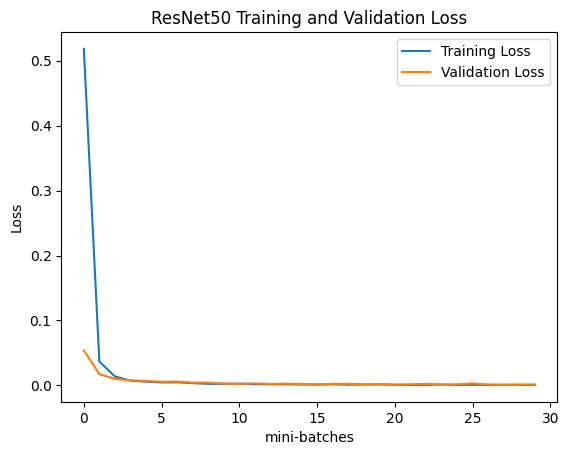

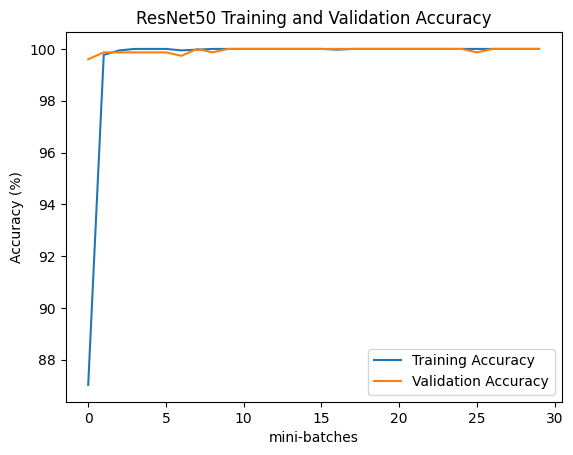

In [91]:
# Plot training loss over time
plt.figure()
plt.plot(res_train_losses, label='Training Loss')
plt.plot(res_val_losses, label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('mini-batches')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy over time
plt.figure()
plt.plot(res_train_accuracy, label='Training Accuracy')
plt.plot(res_val_accuracy, label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('mini-batches')
plt.ylabel('Accuracy (%)')
plt.legend()

### Feature Importance

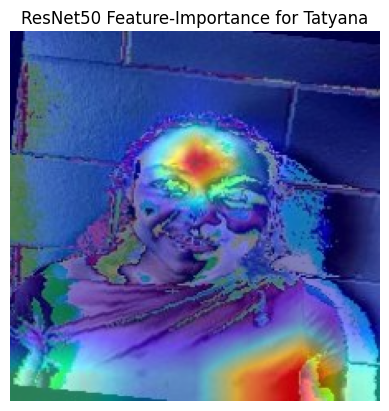

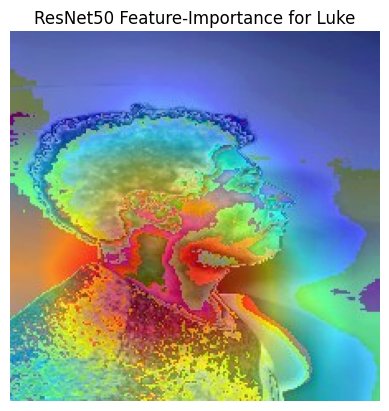

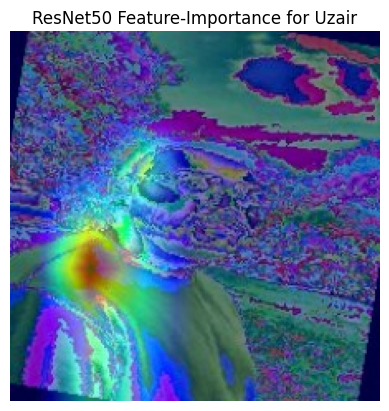

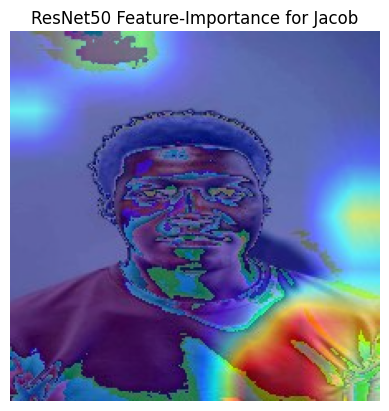

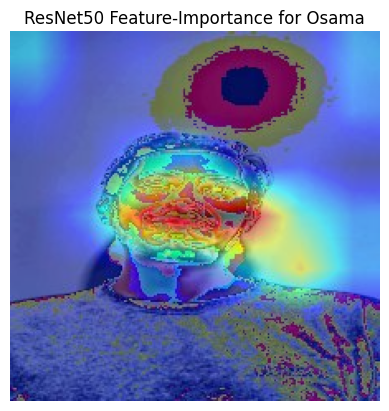

In [92]:
resnet.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/model/best_resnet_model.pth"))
resnet.to(device)
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def preprocess(img_path):
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0
    tensor = normalize(transform(img)).unsqueeze(0).to(device)
    return img_np, tensor

target_layer = resnet.layer4

class_names = ["tatyana", "luke", "uzair", "jacob", "osama"]

cam = GradCAM(model=resnet, target_layers=[target_layer])

for class_idx, class_name in enumerate(class_names):
    folder = f"/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/dataset/FRIENDNETSET/test/{class_name}"
    sample_image = random.choice(os.listdir(folder))

    img_path = os.path.join(folder, sample_image)
    original_img, input_tensor = preprocess(img_path)

    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    visualization = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(f"ResNet50 Feature-Importance for {class_name.capitalize()}")
    plt.axis("off")
    plt.show()

## Model Evaluation

In [93]:
resnet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"ResNet50 Accuracy : {accuracy:.4f}")
print(f"ResNet50 Precision: {precision:.4f}")
print(f"ResNet50 Recall   : {recall:.4f}")
print(f"ResNet50 F1 Score : {f1:.4f}")

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

ResNet50 Accuracy : 1.0000
ResNet50 Precision: 1.0000
ResNet50 Recall   : 1.0000
ResNet50 F1 Score : 1.0000


### Evaluation Visuals

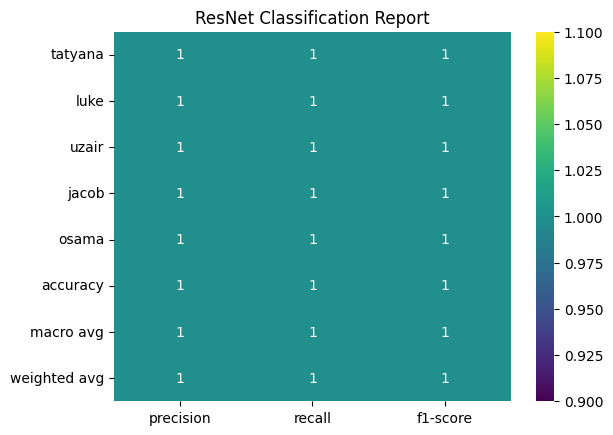

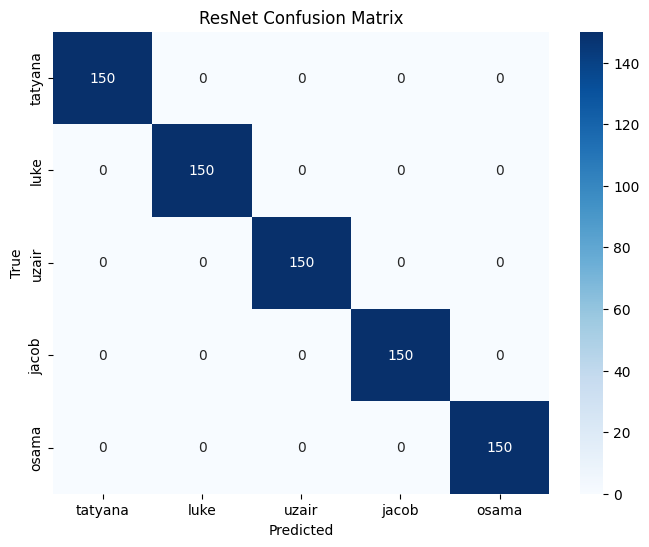

In [94]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='viridis')
plt.title('ResNet Classification Report')
plt.show()

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet Confusion Matrix')
plt.show()

# Finetune on CLIP Model

## Dataset Configurations

In [161]:
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='openai'
)

print(clip_preprocess)

base_path = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/dataset/FRIENDNETSET"

train_dataset = datasets.ImageFolder(root=os.path.join(base_path, "train"), transform=clip_preprocess)
val_dataset   = datasets.ImageFolder(root=os.path.join(base_path, "val"),   transform=clip_preprocess)
test_dataset  = datasets.ImageFolder(root=os.path.join(base_path, "test"),  transform=clip_preprocess)

batch_size = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7fc244609e40>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


## Model Definition

In [162]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip = clip_model
        embed_dim = clip_model.visual.output_dim
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, images, enable_grad=False):
        if enable_grad:
            # Allow gradients for Grad-CAM
            features = self.clip.encode_image(images)
        else:
            # Normal inference without gradients
            with torch.no_grad():
                features = self.clip.encode_image(images)
        return self.classifier(features)

num_classes = 5
clip = CLIPClassifier(clip_model, num_classes)

# Freeze the CLIP backbone, train only the classifier
for param in clip.parameters():
    param.requires_grad = True

print(clip)

CLIPClassifier(
  (clip): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
          )
        )


## Define Hyperparameters

In [140]:
criterion = nn.CrossEntropyLoss()
clip = clip.to(device)
optimizer = torch.optim.SGD(clip.parameters(), lr=0.0001, momentum=0.9)
epochs = 50

print("Loss Fn", criterion)
print("Batch Size", batch_size)
print("Epochs", epochs)
print("Optimizer", optimizer)

total_params = sum(p.numel() for p in clip.parameters())
trainable_params = sum(p.numel() for p in clip.parameters() if p.requires_grad)
print(f"Trainable params: {trainable_params} / {total_params}")

print(train_dataset.class_to_idx)

Loss Fn CrossEntropyLoss()
Batch Size 30
Epochs 50
Optimizer SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Trainable params: 151279878 / 151279878
{'jacob': 0, 'luke': 1, 'osama': 2, 'tatyana': 3, 'uzair': 4}


## Training and Validation

In [141]:
print("Training...")

clip_train_losses = []
clip_train_accuracy = []
clip_val_losses = []
clip_val_accuracy = []

# EARLY STOPPING CONFIG
clip_patience = 30  # Number of epochs to wait before stopping
clip_best_val_loss = float('inf')
clip_early_stop_counter = 0

# path to save the best model
clip_best_model_path = "/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/model/best_clip_model.pth"

for epoch in tqdm(range(epochs), desc="Epochs"):
    clip.train()
    clip_train_loss = 0.0
    clip_train_correct = 0
    clip_total = 0

    for images, labels in tqdm(train_loader, desc="Train Loader"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = clip(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        clip_total += labels.size(0)
        clip_train_correct += (predicted == labels).sum().item()
        clip_train_loss += loss.item() * images.size(0)

    clip_train_losses.append(clip_train_loss / clip_total)
    clip_train_accuracy.append(100 * clip_train_correct / clip_total)

    clip.eval()
    clip_val_running_loss = 0.0
    clip_val_correct = 0
    clip_val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation Loader"):
            images, labels = images.to(device), labels.to(device)

            outputs = clip(images)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            clip_val_total += labels.size(0)
            clip_val_running_loss += loss.item() * images.size(0)
            clip_val_correct += (pred == labels).sum().item()

    clip_current_val_loss = clip_val_running_loss / clip_val_total
    clip_current_val_accuracy = 100 * clip_val_correct / clip_val_total
    clip_val_losses.append(clip_current_val_loss)
    clip_val_accuracy.append(clip_current_val_accuracy)

    print(f"Train Loss: {clip_train_losses[-1]:.4f}, "
          f"Val Loss: {clip_current_val_loss:.4f}, Val Acc: {clip_current_val_accuracy:.2f}%")

    # EARLY STOPPING CHECK
    if clip_current_val_loss < clip_best_val_loss:
        clip_best_val_loss = clip_current_val_loss
        clip_early_stop_counter = 0
        torch.save(clip.state_dict(), clip_best_model_path)
    else:
        clip_early_stop_counter += 1
        if clip_early_stop_counter >= clip_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Finished Training.")

Training...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.5970, Val Loss: 1.5673, Val Acc: 36.93%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.5407, Val Loss: 1.5240, Val Acc: 46.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.4966, Val Loss: 1.4839, Val Acc: 52.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.4557, Val Loss: 1.4462, Val Acc: 57.60%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.4175, Val Loss: 1.4104, Val Acc: 61.20%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.3812, Val Loss: 1.3773, Val Acc: 63.33%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.3471, Val Loss: 1.3459, Val Acc: 64.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.3156, Val Loss: 1.3166, Val Acc: 66.40%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.2857, Val Loss: 1.2889, Val Acc: 66.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.2571, Val Loss: 1.2632, Val Acc: 66.53%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.2310, Val Loss: 1.2387, Val Acc: 68.13%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.2056, Val Loss: 1.2152, Val Acc: 70.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.1819, Val Loss: 1.1932, Val Acc: 70.40%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.1593, Val Loss: 1.1728, Val Acc: 68.13%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.1384, Val Loss: 1.1524, Val Acc: 72.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.1181, Val Loss: 1.1334, Val Acc: 73.20%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.0991, Val Loss: 1.1157, Val Acc: 73.47%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.0808, Val Loss: 1.0986, Val Acc: 74.13%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.0633, Val Loss: 1.0819, Val Acc: 74.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.0465, Val Loss: 1.0663, Val Acc: 75.33%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.0306, Val Loss: 1.0514, Val Acc: 74.93%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.0156, Val Loss: 1.0369, Val Acc: 76.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.0008, Val Loss: 1.0230, Val Acc: 76.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9869, Val Loss: 1.0098, Val Acc: 78.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9737, Val Loss: 0.9966, Val Acc: 78.00%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9608, Val Loss: 0.9842, Val Acc: 78.40%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9481, Val Loss: 0.9724, Val Acc: 78.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9359, Val Loss: 0.9608, Val Acc: 79.07%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9247, Val Loss: 0.9501, Val Acc: 78.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9133, Val Loss: 0.9389, Val Acc: 79.33%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.9027, Val Loss: 0.9287, Val Acc: 79.73%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8922, Val Loss: 0.9189, Val Acc: 80.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8822, Val Loss: 0.9094, Val Acc: 80.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8720, Val Loss: 0.8995, Val Acc: 80.27%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8625, Val Loss: 0.8901, Val Acc: 80.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8534, Val Loss: 0.8819, Val Acc: 81.33%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8445, Val Loss: 0.8727, Val Acc: 81.33%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8359, Val Loss: 0.8640, Val Acc: 81.33%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8274, Val Loss: 0.8557, Val Acc: 81.73%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8193, Val Loss: 0.8478, Val Acc: 81.60%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8113, Val Loss: 0.8401, Val Acc: 82.40%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.8035, Val Loss: 0.8325, Val Acc: 82.53%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7958, Val Loss: 0.8254, Val Acc: 82.80%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7885, Val Loss: 0.8181, Val Acc: 83.47%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7814, Val Loss: 0.8115, Val Acc: 82.67%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7744, Val Loss: 0.8040, Val Acc: 83.87%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7676, Val Loss: 0.7978, Val Acc: 83.60%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7612, Val Loss: 0.7910, Val Acc: 84.13%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7543, Val Loss: 0.7845, Val Acc: 84.40%


Train Loader:   0%|          | 0/117 [00:00<?, ?it/s]

Validation Loader:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.7482, Val Loss: 0.7786, Val Acc: 84.40%
Finished Training.


### Train Visuals

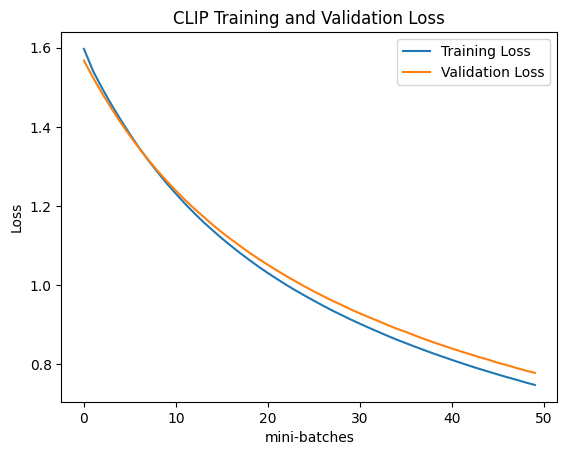

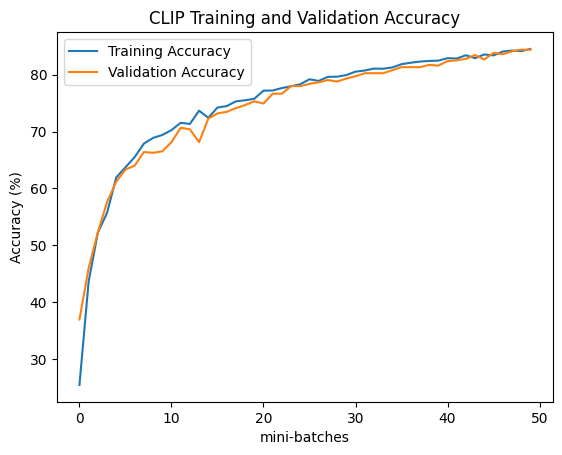

In [158]:
# Plot training loss over time
plt.figure()
plt.plot(clip_train_losses, label='Training Loss')
plt.plot(clip_val_losses, label='Validation Loss')
plt.title('CLIP Training and Validation Loss')
plt.xlabel('mini-batches')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy over time
plt.figure()
plt.plot(clip_train_accuracy, label='Training Accuracy')
plt.plot(clip_val_accuracy, label='Validation Accuracy')
plt.title('CLIP Training and Validation Accuracy')
plt.xlabel('mini-batches')
plt.ylabel('Accuracy (%)')
plt.legend()

## Model Evaluation

In [163]:
clip.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Pytorch/Project/model/best_clip_model.pth"))
clip.to(device)
clip.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = clip(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"CLIP Accuracy : {accuracy:.4f}")
print(f"CLIP Precision: {precision:.4f}")
print(f"CLIP Recall   : {recall:.4f}")
print(f"CLIP F1 Score : {f1:.4f}")

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

CLIP Accuracy : 0.8427
CLIP Precision: 0.8509
CLIP Recall   : 0.8427
CLIP F1 Score : 0.8415


### Evaluation Visuals

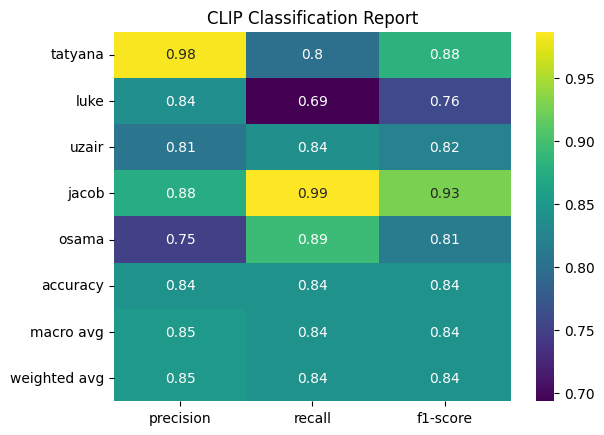

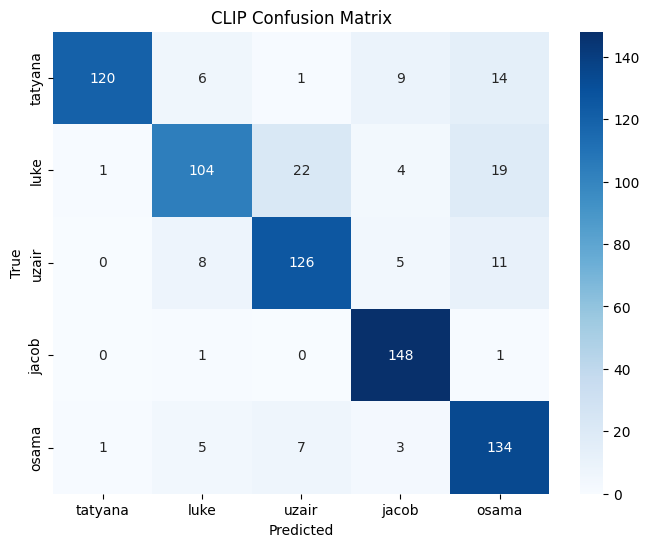

In [144]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='viridis')
plt.title('CLIP Classification Report')
plt.show()

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CLIP Confusion Matrix')
plt.show()